# CAM, Grad-CAM

In [36]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image
import os

In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. 데이터 준비

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    "stanford_dogs",
    split=["train", "test"],
    shuffle_files=True,
    with_info=True
)

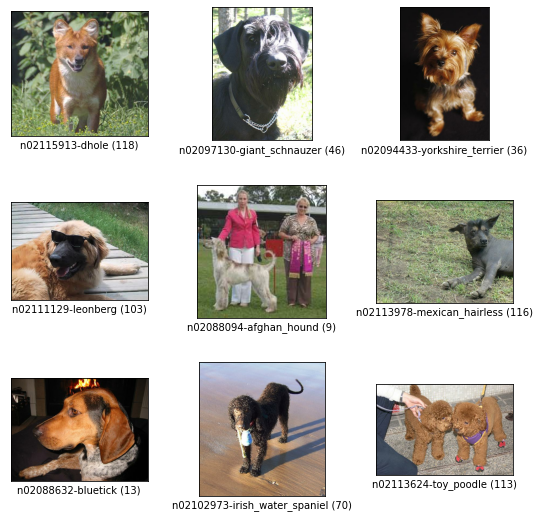

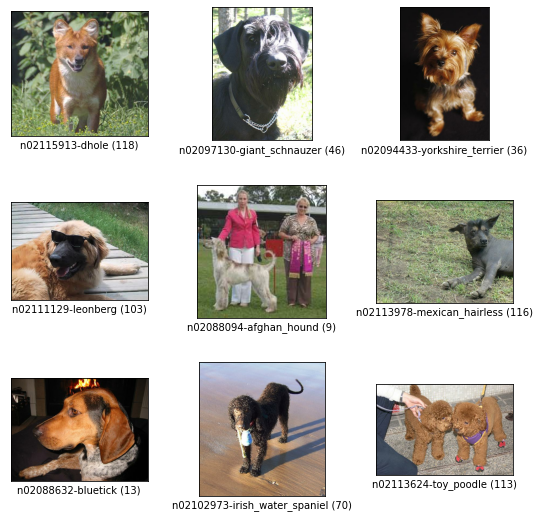

In [7]:
tfds.show_examples(ds_train, ds_info)

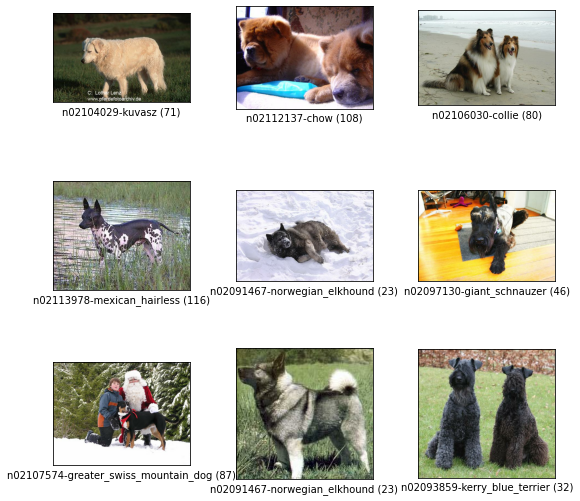

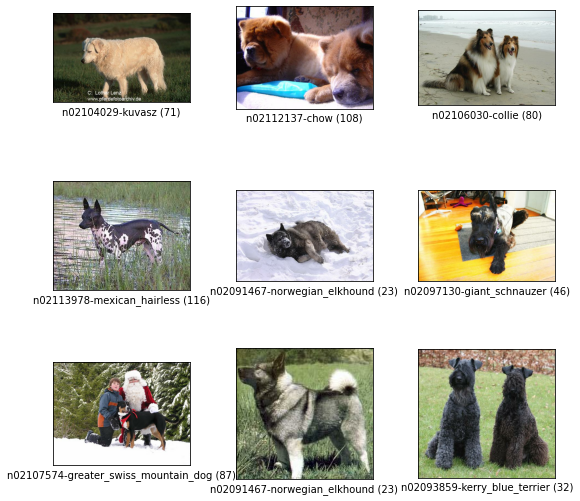

In [8]:
tfds.show_examples(ds_test, ds_info)

In [9]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

## 2. 모델 구성

In [17]:
num_classes = ds_info.features["label"].num_classes

def get_resnet50():
    return keras.applications.resnet50.ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3),
        pooling="avg"
    )

base_model = get_resnet50()
x = base_model.output
preds = keras.layers.Dense(120, activation=keras.activations.softmax)(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [19]:
cam_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [20]:
def normalize_and_resize_img(input):
    image = tf.image.resize(input["image"], (224, 224))
    input["image"] = tf.cast(image, tf.float32) / 225.
    return input["image"], input["label"]

In [29]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    
    ds = ds.batch(batch_size)
    
    if not is_test:
        #ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [30]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test, is_test=True)

In [31]:
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [32]:
cam_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=["accuracy"])

In [41]:
os.makedirs("./history", exist_ok=True)
csv_logger = keras.callbacks.CSVLogger("./history/basic_e2.log")

history_cam_model = cam_model.fit(
    ds_train_norm,
    validation_data=ds_test_norm,
    callbacks=[csv_logger],
    steps_per_epoch=int(ds_info.splits["train"].num_examples/16),
    validation_steps=int(ds_info.splits["test"].num_examples/16),
    epochs=2,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/2
750/750 [==============================] - 169s 219ms/step - loss: 0.6887 - accuracy: 0.8025 - val_loss: 1.3942 - val_accuracy: 0.6070
Epoch 2/2
750/750 [==============================] - 157s 206ms/step - loss: 0.1845 - accuracy: 0.9607 - val_loss: 1.4475 - val_accuracy: 0.6187


In [45]:
import os

cam_model_path = "/aiffel/aiffel/class_activation_map/"
cam_model_weights = "cam_model1_cp-{epoch:04d}.keras"

cam_model.save(cam_model_path+cam_model_weights.format(epoch=2))

## 3. CAM

In [43]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

67


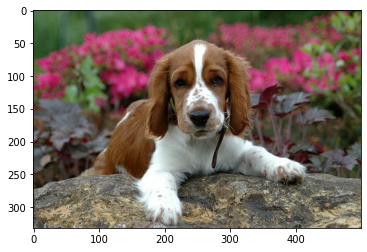

In [44]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [47]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1_cp-0002.keras'
cam_model = tf.keras.models.load_model(cam_model_path)

In [53]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item["image"].shape[1]
    height = item["image"].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    cam_model = keras.models.Model(
        inputs=[model.inputs], 
        outputs=[model.layers[-3].output, model.output]
    )
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    class_weights = model.layers[-1].get_weights()[0]
    
    cam_image = np.zeros(shape=conv_outputs.shape[0:2], dtype=np.float32)
    for i, w in enumerate(class_weights[:, class_idx]):
        cam_image += w * conv_outputs[:, :, i]
        
    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, dsize=(width, height))
    return cam_image
    

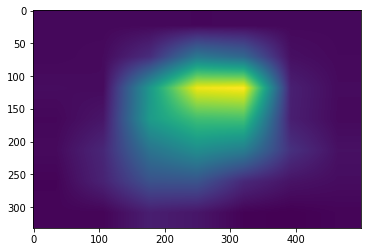

In [54]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [61]:
# 원본 이미지와 합치기
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = 1 - alpha
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

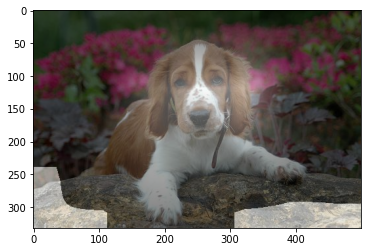

In [63]:
origin_image = item["image"].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## 4. Grad-CAM

84


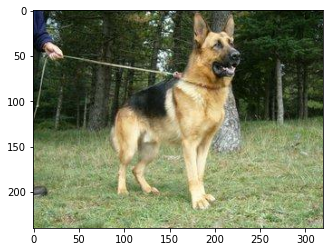

In [64]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [100]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item["image"].shape[1]
    height = item["image"].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    grad_cam_model = keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(activation_layer).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, pred = grad_cam_model(tf.expand_dims(img_tensor, 0))
        pred = pred[:, class_idx]
        output = conv_output[0]
        grad_val = tape.gradient(pred, conv_output)[0]
    
    weights = np.mean(grad_val, axis=(0, 1))
    
    grad_cam_image = np.zeros(shape=conv_output.shape[0:2], dtype=np.float32)
    for i, w in enumerate(weights):
        grad_cam_image += w * output[:, :, i]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, dsize=(width, height))
    return grad_cam_image
    

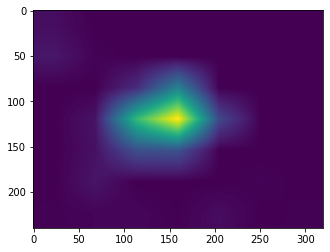

In [101]:
grad_cam_image = generate_grad_cam(cam_model, "conv5_block3_out", item)
plt.imshow(grad_cam_image)
plt.show()

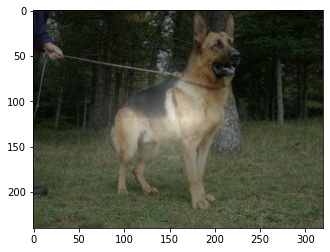

In [103]:
origin_image = item["image"].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## 5. Bounding Box

116


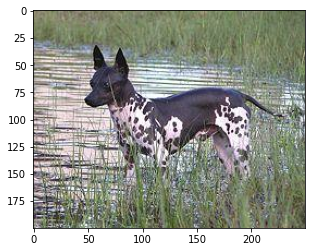

In [104]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

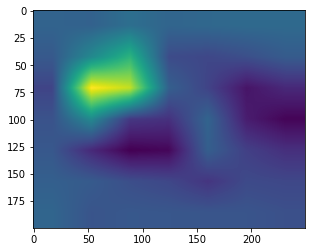

In [105]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [106]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [107]:
rect = get_bbox(cam_image)
rect

array([[  3,  31],
       [ 99,  -7],
       [133,  75],
       [ 37, 115]])

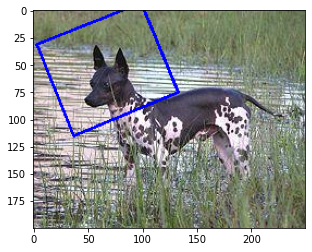

In [108]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [109]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),
        rect[:,0].min()/float(image.shape[1]),
        rect[:,1].max()/float(image.shape[0]),
        rect[:,0].max()/float(image.shape[1])
    ]
    return bbox

In [112]:
# prediction bbox
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.035, 0.012, 0.575, 0.532]

In [111]:
# ground truth
item['objects']['bbox']

array([[0.165, 0.192, 0.8  , 0.924]], dtype=float32)

In [113]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [114]:
# IoU
get_iou(pred_bbox, item['objects']['bbox'][0])

0.21692446077960612